<a href="https://colab.research.google.com/github/marijakotur/BunchLength/blob/master/yelp_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, confusion_matrix

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from datetime import datetime
import torch




In [ ]:
! pip install -q setfit
! pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.8 MB/s eta 0:0

In [ ]:
!pwd

/content


In [ ]:
%cd content

[Errno 2] No such file or directory: 'content'
/content


In [ ]:
# from lib.evaluation_helpers import *

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
!pwd

Mounted at /content/gdrive/
/content


In [ ]:
%cd ./gdrive/MyDrive/yelp
!ls

/content/gdrive/MyDrive/yelp
Dataset_User_Agreement.pdf	     yelp_academic_dataset_checkin.json
df_restaurants_with_labels.csv	     yelp_academic_dataset_review.json
models				     yelp_academic_dataset_tip.json
restaurant_reviews_2017_2022.csv     yelp_academic_dataset_user.json
restaurants_2017_2022.csv	     yelp_dataset.tar
yelp_academic_dataset_business.json


In [ ]:
# load a prepared restaurants data, latest 5 years available
df = pd.read_csv('restaurant_reviews_2017_2022.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
len(df)

634490

In [ ]:
# df.head()

In [ ]:
# reviews per restaurant
print(df.business_id.nunique())
df.business_id.value_counts() #.hist(bins=100)

12517


ac1AeYqs8Z4_e2X5M3if2A    5123
oBNrLz4EDhiscSlbOl8uAw    3464
VaO-VW3e1kARkU9bP1E7Fw    2196
3iUCCf1FWmjlFbGYvBgf9w    2133
DcBLYSvOuWcNReolRVr12A    1670
                          ... 
PsbPB_5GxWPiayrNJM7V9Q       1
NpglDX_FUp3ybEzbBp4qhw       1
8QeaCReOO-ryojndLvkBNg       1
igC3UWYb9RF5CXOQOVypMw       1
0vksR9cowkTN_xL-sdZnNw       1
Name: business_id, Length: 12517, dtype: int64

In [ ]:
df_fitered = df[df.groupby('business_id').business_id.transform('count') > 10]

In [ ]:
df_fitered.business_id.value_counts() #.hist(bins=100)

ac1AeYqs8Z4_e2X5M3if2A    5123
oBNrLz4EDhiscSlbOl8uAw    3464
VaO-VW3e1kARkU9bP1E7Fw    2196
3iUCCf1FWmjlFbGYvBgf9w    2133
DcBLYSvOuWcNReolRVr12A    1670
                          ... 
LDt_M0pnRA-YxOidX5f4_Q      11
g1o1XGR4vA85paP6G9S9DQ      11
jE29lzOBKz7Fwkdec6-Abw      11
vqQQtSUxAnoD6q0KbkmNcA      11
uzjR6SIeNZUxSvya4SsKKQ      11
Name: business_id, Length: 8788, dtype: int64

In [ ]:
words = ["poison","diar","sick","puk","salmonella","chunder","spew","vom","throw up","threw up","nause","inspect"]

df_risk = df[['business_id', 'review_id', 'date', 'stars','text']].loc[df['stars']>=1].loc[df['text'].str.contains('|'.join(words))].reset_index()
len(df_risk)

5794

In [ ]:
user_agg=df.groupby('user_id').agg({'review_id':['count'],'date':['min','max'],
                                'useful':['sum'],'funny':['sum'],'cool':['sum'],
                               'stars':['mean']})

In [ ]:
user_agg.head(2)

review_id                 date                       \
                           count                  min                  max   
user_id                                                                      
---zemaUC8WeJeWKqS6p9Q         1  2021-06-23 08:17:42  2021-06-23 08:17:42   
--17Db1K-KujRuN7hY9Z0Q         1  2017-10-01 20:24:24  2017-10-01 20:24:24   

                       useful funny cool stars  
                          sum   sum  sum  mean  
user_id                                         
---zemaUC8WeJeWKqS6p9Q      1     0    1   5.0  
--17Db1K-KujRuN7hY9Z0Q      1     1    4   5.0

Text(0, 0.5, '# of users')

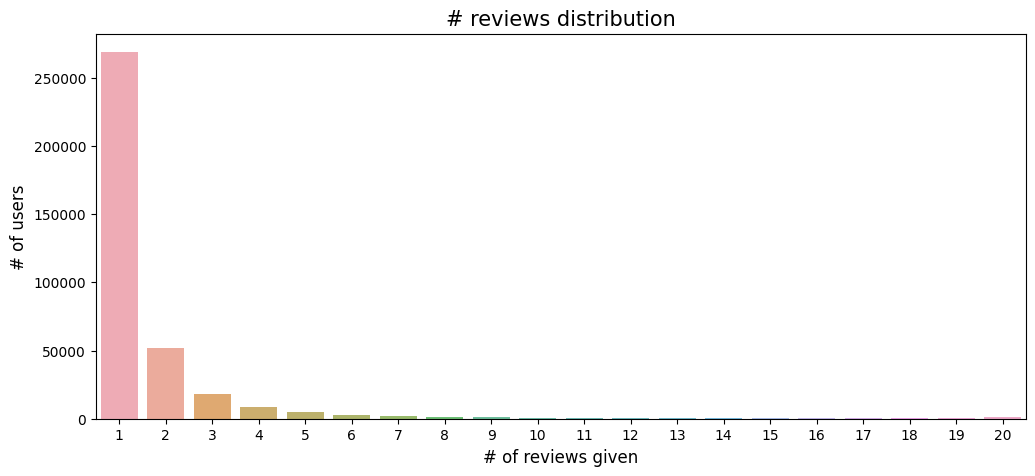

In [ ]:
user_agg[('review_id','count')].loc[user_agg[('review_id','count')]>20] = 20
plt.figure(figsize=(12,5))
#Cumulative Distribution
x = user_agg[('review_id','count')].value_counts()
sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("# reviews distribution", fontsize=15)
plt.xlabel('# of reviews given', fontsize=12)
plt.ylabel('# of users', fontsize=12)

<Axes: title={'center': 'All restaurant reviews'}, xlabel='stars', ylabel='# instances'>

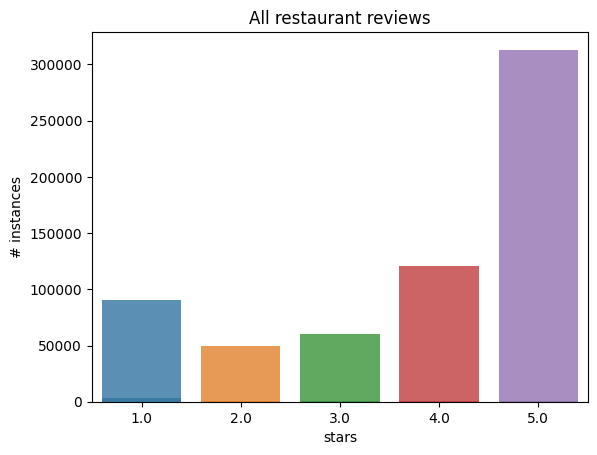

In [ ]:
x=df['stars'].value_counts()
x=x.sort_index()
sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.xlabel('stars')
plt.ylabel('# instances')
plt.title('All restaurant reviews')

r=df_risk['stars'].value_counts()
r=r.sort_index()
sns.barplot(x=r.index, y=r.values, alpha=0.8)

In [ ]:
pd.set_option('max_colwidth', -1)
df[df.stars==2].sample(5)

<ipython-input-18-78241cbe4c7b>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
575907,3wO5d_dOtVzYvb08D7cAlg,THGZQJq3KP0-lc3-i864jQ,ZSwDwV4o8MvX8cwMgfE0LA,2.0,0,0,0,"Staff is always very nice. But every time I have been here the food is severely disappointing. 1st trip was sunny side up eggs on hash browns. the eggs were still a little runny on the edges. I believe they use water to help cook the eggs. Unfortunately that water was carried over to the plate. so under the hash browns was a giant puddle of water, rolling around the plate. Got a waffle on another occasion, it came with a side of syrup... Log cabin? Aunt Jemima? not real maple syrup - for what you pay for a waffle there you should get real maple syrup. Tried the filled crepes on another visit. the filling is ridiculously sweet. Eggs Benedict was flavorless. the last visit I got an omelette, it was one of their specialty omelettes with artichoke and some other stuff in it. It was edible, not much flavor but very forgettable.",2018-02-16 04:42:12
106875,uBHlYjC8DilzLjrH3dnFcg,79mBe4zMHO1VQxSPk3aNbQ,Jw3mUNF9_ZiawPDZryUdcw,2.0,0,0,0,"I was really hungry and saw the restaurant and walked in. Read some reviews while waiting for the wait staff which didn't show up for about 20 minutes into my visit. The place wasn't that busy (maybe 4-6 tables outside), so not sure why it took so long. Ordered the clam chowder and fisherman's feast. Both were extremely underwhelming. Not sure if it was off night, but the soUp came out warm, not hot, and was bland. There was no salt at the table, so just had to make due. Then the main entree came out, and it was just bad. Scallops were over cooked, shrimp was over cooked, and the tilapia loooed disgusting. I asked for fried (probably shouldn't have) but everything came out smushy and soggy. Weird thing tho was the rice and broccoli (which was supposed to be steamed) were undercooked - rice was hard and broccoli was still crispy. The ambiance is great, which is why I give it 2 stars. But in a beachfront are with heavy competition for sea food, this was bad. Was going to order more to go, but after eating half my plate, I started to feel nauseous from eating and stopped. Definitely would not recommend to go eat here, but may be a cool place to drink. Just don't sit outside at the tables where the wait staff ignores you. Took an extra 10 minutes to get my check because one waitress was missing and the other was chatting with one person, while 4 other tables were just sitting and waiting. Bad look.",2019-12-11 05:19:45
395079,mTdZ87l9vWIk8bn2LKDg-w,mz7JG9yfkyP4uE577Dnkug,dhTqIxY42I_X3kk3xk367w,2.0,0,1,0,If you are white don't go & sit down for dining - you will get treated different. I asked for salt & pepper & was brought take out salt & pepper packets. When I looked over all the other guests had a salt & pepper shaker- which is what I was expecting! I guess she was trying to tell me what I already knew- I was out of place! I also had to ask for another beverage and never got it!,2018-11-02 00:41:50
283748,ZHUXp0-AO7eOCYkDDv4obw,1uzkynuDsx18du5xeDSnjg,xYt01b3U9wTPe1Ysx1-u7Q,2.0,2,0,0,"I'm writing this review today as we are sitting down to eat right now. First off the service here is hit or miss. Sometimes we get good service some times we get crap service. To start off we were seated and our server walked past us twice and made eye contact. After waiting fo 5 mins to get service, we ordered our drinks. After ordering our food we watched someone get seated and they got immediate service within seconds. \n\nFirst off are we sure they get proper training or do you just throw them out into the dinning area and expect them to give the customers world class service, or do we not care. I have been in the industry for years now and I know I thrive to give all my customers amazing service I would think you would two. \n\nSecond off We do have a favorite waitress she is fantastic I think your team could learn a lot from her and she should be doing the training for 

In [ ]:
# df_risk.info()

In [ ]:
# df_risk['text'].sample().to_list()

In [ ]:
# negative
# H_BDHSjR1w3owLLHNp74ug
# USvARgck4odZHKZcn-6YPA	
# d5AcHe-oOO8yzys5O9LfwA	
# WphWzGzhKKQ4UElttnYYmg
# PDgGhVDArvB-qkgiIgV9tA	
# ZHUXp0-AO7eOCYkDDv4obw

In [ ]:
# pass heuristics but actually negative
# 7vnxYp2NuSKPFZUWRQEC-g
# g67sRtksNCV5GbGQnLMkeQ
# BXHYGinJZpfKGZkypFwXbQ
# B-5PDoM2NCtVjATqjFhDYg	
# NFiiMjpiFeZdxJiH-gXusQ	
# R8twFcSpb6NG4BRHv_UpzA
# h5hjYnnlUIBzPrdK50VP3A
# WfQTmpPiQpqj1UJKbGLDBQ
# 1d_vunwCcCACCuHBv1rlvA
# EVFhCn3qbhmrRziUqGRtFA
# uv9-xdGaIdxxpjyPiMUQ3A	
# ejQXc8FeVQCldiCKSOCDhA
# RWSzHYUXZFQ3EnxMYGGyPA
# jBjizriDUfKUbFamcS_Adw
# OCkwLemW7nwU_eE4YbBSDw
# _o8ob1f62bVyUl77kb0x4Q
# PlrW_O4i5-wglkk1JwDvvw	

In [ ]:
# actual food poisoning cases
# 'Sausage and cheese plate came out first. Sausage seemed a little underdone. Ordered the ribs and brisket. Asked for both to be "wet". Brisket was amazing but ribs were very very dry.\n\nIt was a 3 star review...but now that I can finally sit up and stop vomiting, I\'m updating it to 1 only because Yelp! has it in their head that no place can be 0/5. \n\nEnded up getting food poisoning from the undercooked meat. Absolutely 0 excuse for this as were the first customers of the day at 11am.'
# eA_fMgPpQyBzpRIurzjQPQ
# LS_MlEqEBlkdo3idxla0BA
# -IuEjeRC9-n72-lueLHigQ	
# orBq-38ilruKN7gweWXQGg	
# Pvoza1umRqfY55cn4W6ijg

# XW4DPQfRORq5W9vcqBqFDw
# 9_H4WGPHewYN8tEeHHRPgQ
# jW16cXsIpLn74GPRrsJXJA	
# Bh6OUdKW5qxl3WF_GtwPsw
# r77rTnEwf3rApPtoKWC79g

# BgFc4YOvvEcu2V-dc0ZS6w	
# iE90c2EeZARsgVjK8gI6mQ
# hlA-6W2wr8dJ5M7Ik8dYHw	
# E2Kn2Yoj1e0khb_kNCNNiQ
# vMXkHKa9btjlY5XRK7EBmg

# 71QNjefP6A5s4ceQDWmi-w	
# M6_eSAitltfThIJsbKe4jg	
# jTx8n6PHDFA2-_Yei60Riw	
# w913cbZ0v2DO-gbEIuZJFw	
# LAx2I1B7j16-uxJWZgL_nQ	

# z0gPQAuqHvOUeY2s5sqnuA
# TcwYLJR5fXZBOSnp_iNCow	
# yWtBeiFdmmkofKVREw3quQ
# L2iugdG5VzW0Ytj9nppB7A
# j91bipnMz2Zx74vn_141Bw	

# aoQXkwQpkJzkXb4hVggjYw
# jSBRdrnjTn0tYM30dkeDog
# TmijUtpuOJuO4ZRV7TG6xA
# PTHNqjY0FW9i9l7Qbe2yHg
# rCgVYX4kzyyx1u01Vmjq7g

# XiftlbJmxRopAzYHsogWvQ	
# sQo4yjfd_nnN8k6GtRcvug
# WdRoBna_n057TEhB279FQg	
# Y4UJnUM8Lg6eYGEsyy5X2w
# XW4DPQfRORq5W9vcqBqFDw

# 7pu0XR_ywK13WmRJwVG9FA
# NTW_xpHayZYqGV_UUWqVRA
# akTuZ2w67H9T-TvT04AEpg	
# HKFrGHIxt2sQIXpOSQwQ3Q	
# zE5y5_OzyzoTMYLPbNw65g

# F4EVrf05MIFO83c3GM02Yg

In [ ]:
food_poisoning = ['eA_fMgPpQyBzpRIurzjQPQ', 'LS_MlEqEBlkdo3idxla0BA', '-IuEjeRC9-n72-lueLHigQ', 'orBq-38ilruKN7gweWXQGg', 'Pvoza1umRqfY55cn4W6ijg','XW4DPQfRORq5W9vcqBqFDw', \
                  '9_H4WGPHewYN8tEeHHRPgQ', 'jW16cXsIpLn74GPRrsJXJA', 'Bh6OUdKW5qxl3WF_GtwPsw', 'r77rTnEwf3rApPtoKWC79g', 'BgFc4YOvvEcu2V-dc0ZS6w','iE90c2EeZARsgVjK8gI6mQ', \
                  'hlA-6W2wr8dJ5M7Ik8dYHw', 'E2Kn2Yoj1e0khb_kNCNNiQ', 'vMXkHKa9btjlY5XRK7EBmg', '71QNjefP6A5s4ceQDWmi-w', 'M6_eSAitltfThIJsbKe4jg','jTx8n6PHDFA2-_Yei60Riw', \
                  'w913cbZ0v2DO-gbEIuZJFw', 'LAx2I1B7j16-uxJWZgL_nQ', 'z0gPQAuqHvOUeY2s5sqnuA', 'TcwYLJR5fXZBOSnp_iNCow', 'yWtBeiFdmmkofKVREw3quQ', 'L2iugdG5VzW0Ytj9nppB7A', \
                  'j91bipnMz2Zx74vn_141Bw', 'aoQXkwQpkJzkXb4hVggjYw', 'jSBRdrnjTn0tYM30dkeDog', 'TmijUtpuOJuO4ZRV7TG6xA', 'PTHNqjY0FW9i9l7Qbe2yHg','rCgVYX4kzyyx1u01Vmjq7g', \
                  'XiftlbJmxRopAzYHsogWvQ',	'sQo4yjfd_nnN8k6GtRcvug', 'WdRoBna_n057TEhB279FQg', 'Y4UJnUM8Lg6eYGEsyy5X2w', '7pu0XR_ywK13WmRJwVG9FA', 'NTW_xpHayZYqGV_UUWqVRA',\
                   'akTuZ2w67H9T-TvT04AEpg', 'HKFrGHIxt2sQIXpOSQwQ3Q', 'zE5y5_OzyzoTMYLPbNw65g', 'F4EVrf05MIFO83c3GM02Yg']


In [ ]:
# [(i, df[df['review_id']==f].user_id) for i,f in enumerate(food_poisoning)]

In [ ]:
# food_poisoning.sort()
# print(food_poisoning)

In [ ]:
pat = '|'.join(r"\b{}\b".format(x) for x in food_poisoning)
df_pos = (df[df['review_id'].str.contains(pat)])

In [ ]:
df_pos.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
1666,NTW_xpHayZYqGV_UUWqVRA,JFzmxJlZy4IRjZcF3PjAmg,kPG6r0h73sPgXBei0MyzYg,1.0,0,0,0,I am beyond disappointed with Numchok Wilai to...,2018-08-26 04:27:25
22307,j91bipnMz2Zx74vn_141Bw,EJPcz79biEXbA4sirxW55w,SuQgcpL-aZeuyRjBdA0pHw,1.0,4,1,0,Me and a friend ordered from Samurai this past...,2018-02-27 21:48:35
30543,TcwYLJR5fXZBOSnp_iNCow,5nzUTbI55UO3RGtamMbPnw,gK9CdFaCXmHoW8aLfXiSqg,1.0,1,0,0,"Last night, my boyfriend and I ate at the Ferm...",2020-02-25 16:12:30
35858,jW16cXsIpLn74GPRrsJXJA,F51qnPvEbluCiF5IJ1AqSA,XMGjDIAFbu9VSmWDs-Ev5w,1.0,0,0,0,Placed a pick up order for two Haven Burgers a...,2020-04-24 15:01:31
37581,jSBRdrnjTn0tYM30dkeDog,r0bXaN4z4sN6RGjAClEx_A,zVlhs7BVaouutt-rles-YA,1.0,0,0,0,Was in the area and love small mom and pop sho...,2019-02-04 13:09:14


<Axes: >

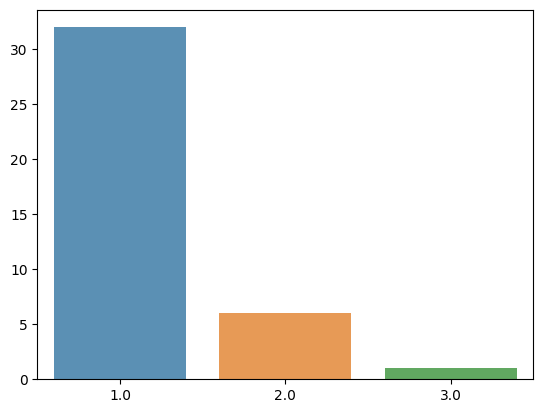

In [ ]:
p=df_pos['stars'].value_counts()
p=p.sort_index()
sns.barplot(x=p.index, y=p.values, alpha=0.8)

In [ ]:
df_pos['stars'].value_counts()

1.0    32
2.0     6
3.0     1
Name: stars, dtype: int64

In [ ]:
# # use a heuristic to find wreviews indicating risk
# # Load the review data
    
# words = ["poison","diar","sick","puk","salmonella","chunder","spew","vom","throw up","threw up","nause"]
# count = 0 

# highRiskReviews = pd.DataFrame(columns=['business_id', 'date', 'text'])
# normalReviews = pd.DataFrame(columns=['business_id', 'date', 'text'])

# # Iterate through the reviews and save high risk reviews to highRiskReviews
# for index,review in enumerate(reviews):
#     reviewData = json.loads(review)
    
#     # if text contains one of the key words, and is 1 star or less then append to the data frame
#     if any(word in reviewData['text'] for word in words) and reviewData['stars'] < 2:
#         highRiskReviews = highRiskReviews.append({'business_id': reviewData['business_id'], 'date': reviewData['date'], 'text': reviewData['text']}, ignore_index=True)
    
#     # because of the size of the data set, pick approx one in every 200, without key words as normal reviews
#     if np.random.randint(1,180) == 1 and not any(word in reviewData['text'] for word in words):
#         normalReviews = normalReviews.append({'business_id': reviewData['business_id'], 'date': reviewData['date'], 'text': reviewData['text']}, ignore_index=True)
#         count += 1
    
# print(highRiskReviews.info())
# print(normalReviews.info())

In [ ]:
# create training data, test data

# shuffle df_pos
df_pos = df_pos.sample(frac=1)
df_rest =  df[~(df['review_id'].isin(df_pos['review_id']))]

# add label columns to df_pos and df_rest
df_pos['label'] = 1
df_rest['label'] = 0


# df_train_pos = df_pos.iloc[:16]
# df_train_neg = df_rest.sample(100)
# df_test_pos = df_pos.iloc[16:]
# df_test_neg = df_rest.sample(100)


df_train_test = pd.concat([df_pos, df_rest], ignore_index=True).sample(frac=1).reset_index(drop=True)


In [ ]:
# index=False
df_train_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,label
0,CJ8MhLyih0djxGjHeT8CJg,rzRuWYc9-JOCtx2VbcxaZg,7wpTBtY2kiMXmW42zvL-fw,5.0,0,0,0,This is a hidden gem in Kenner. The food is au...,2017-12-31 16:09:05,0
1,rgwhBojDxZdzK_Xlp0vqDQ,Frc3-Zty9FA2Xsna3Xb3KQ,HSyOKS1cbfNWFoRCARNfcw,4.0,0,0,0,"As a current southerner, King Ribs is one of t...",2021-12-31 00:22:54,0
2,jFUKtdbLbkJDVyo9vyGZ6Q,EaVCtGYGCmyCoPMxjylg9w,n_Dd2ZreYlX8Xg1Vw47BXQ,5.0,0,0,0,I recently traveled to Boyertown for my mom's ...,2021-06-02 20:39:45,0
3,QOTbllnuuXiM4aK3MtlWXQ,hUEP7M-qW6rx62lS5njRCA,LgaPsosgAnyNst8X--xnIA,4.0,0,0,0,First time here. Was seated right away. Valeri...,2019-11-02 00:57:22,0
4,tAvfXeZkEI9I5x-V-UNCAA,82qrna91pABqDv0nGkEfOg,kRvZUnDK3Rn7a7WvGUZ6QQ,5.0,0,0,0,This place is a hidden treasure great food ser...,2020-09-05 01:17:33,0


In [ ]:
# df_train_test.to_csv("data/df_restaurants_with_labels.csv")

In [ ]:
! cp /content/gdrive/MyDrive/yelp/df_restaurants_with_labels.csv /content/data

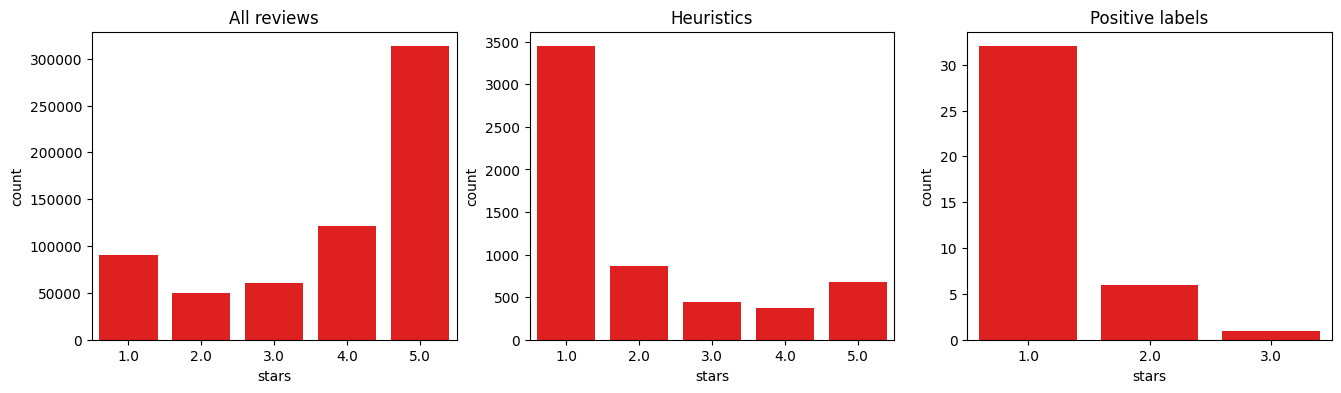

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
sns.countplot(data=df, x=df.stars, ax=ax[0], color="Red")
sns.countplot(data=df_risk, x=df_risk.stars, ax=ax[1], color="Red")
sns.countplot(data=df_pos, x=df_pos.stars, ax=ax[2], color="Red")
ax[0].title.set_text('All reviews')
ax[1].title.set_text('Heuristics')
ax[2].title.set_text('Positive labels')

In [ ]:
# ! pip install setfit
# ! pip install transformers

In [ ]:
train_dataset, test_dataset = {}, {}
data = Dataset.from_pandas(df_train_test[['text','label']])
data = data.class_encode_column("label")
data = data.train_test_split(test_size=0.3,
                    stratify_by_column="label",
                    shuffle=True)

train_dataset = data["train"]
test_dataset = data["test"]

# downsample majority class in train_dataset
set_1 = train_dataset.filter(lambda x: x["label"]==1)
set_0 = train_dataset.filter(lambda x: x["label"]==0)
seed = 42
train_dataset = concatenate_datasets([
  set_1,
  set_0.shuffle(seed=seed).select(range(150)),
  ])

# downsample majority class in test_dataset
set_1 = test_dataset.filter(lambda x: x["label"]==1)
set_0 = test_dataset.filter(lambda x: x["label"]==0)
seed = 42
test_dataset = concatenate_datasets([
  set_1,
  set_0.shuffle(seed=seed).select(range(150)),
  ])

Stringifying the column:   0%|          | 0/634490 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/634490 [00:00<?, ? examples/s]

Filter:   0%|          | 0/444143 [00:00<?, ? examples/s]

Filter:   0%|          | 0/444143 [00:00<?, ? examples/s]

Filter:   0%|          | 0/190347 [00:00<?, ? examples/s]

Filter:   0%|          | 0/190347 [00:00<?, ? examples/s]

In [ ]:
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    metric="precision",
    batch_size=8,
    num_iterations=2,  # 20, 
    num_epochs=2,  
)

In [ ]:
# del trainer

In [ ]:
# Train and evaluate
trainer.train()
# trainer.train(show_progress_bar=False)

***** Running training *****
  Num examples = 708
  Num epochs = 2
  Total optimization steps = 178
  Total train batch size = 8


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/89 [00:00<?, ?it/s]

Iteration:   0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:
metrics = trainer.evaluate()
# trainer.model.save_pretrained("models/model1")

***** Running evaluation *****


TypeError: ignored

In [ ]:
# print(f"model used: {model_id}")
print(f"train dataset: {len(train_dataset)} samples")
# print(f"accuracy: {metrics['precision']}")
print(f"metriker: {metrics}")

train dataset: 177 samples
metriker: {'precision': 0.8571428571428571}


In [ ]:
# print(f"model used: {model_id}")
print(f"train dataset: {len(train_dataset)} samples")
# print(f"accuracy: {metrics['precision']}")
print(f"metriker: {metrics}")

In [ ]:
probs=model.predict_proba(test_dataset['text'])

In [ ]:
np.round(probs[:,1])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)

In [ ]:
eval_dataset = pd.DataFrame(test_dataset) 
eval_dataset['pred'] = np.round(probs[:,1])

In [ ]:
pd.set_option('max_colwidth', -1)
eval_dataset.iloc[50:60]

<ipython-input-60-4961edb1c62d>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,text,label,pred
50,"Don't even waste your time placing an order! Wanted to grab salad on my way home one evening. Something told me to order from\nSomewhere closer to my house but Pete's was closer at the time so I ordered. I was given a 20 minute pick up time. Fine, it's a Friday night and I was already put on hold for few a minutes so I figured they were busy. I took my time getting there and sat in the car. Giving them a good 25 minutes. I get there and still sit in the car for 5 minutes. Get inside, someone greets me and tell me that someone will be right with me. Meanwhile it's 4 employees behind the counter. My wait is another 5 minutes. Someone finally comes out the back I give them my name and he gives me a total. Before I pay I ask is it ready. He says not yet. I ask because I can't wait at first he flags me, then he says 5 minutes then walks away from the counter to start yelling at another employee. I can't make this stuff up so I left. Never again. They need customer service training badly. They do not appreciate for their customers and don't care for your business. The worst ever! Stay away.",0,0.0
51,"Have used them for takeout, dine in and catering. Will never use them for takeout again. Our last experience was one of our worst....ever. The grilled chicken caesar salad wrap consisted of no chicken - literally ZERO chicken - a few pieces of romaine and a small amount of dressing. I reached out to the store via Facebook and got no response. Have been back since but only for dine in.",0,0.0
52,I went with my family to have breakfast and 2 meals had broken glass inside the food!!! I chewed a piece of glass and couldn't believe it!! I've been sick to my stomach since this morning. My dad stop eating his meal. They still charged us for his meal and his girlfriend's meal. They didn't charge the meals with the broken glass inside the food. That was the second time I went. The first time my waiter was so rude. I would never go to this place and would warn people about this restaurant.,0,1.0
53,"If I could give a million stars I would. We catered our New Years party from Altomonte's. It was perfection. Everyone enjoyed everything! It was a very busy holiday season and they made me feel like I was their only customer. Vicki kept in touch with me, delivery was on time and professional, food was fresh, delicious and was beautifully prepared. Compliments to the chef. I posted a bunch of pictures...hopefully that will help others. I highly recommend the pouched salmon. That was the best pouched salmon I have ever had. The potato salad was delicious and the filet mignon crostini's were also amazing. Actually it was all sooo good! our fresh fruit salad was not on the delivery truck and Vicki called me right away to let me know someone would drop it off. That too came in a timely manner. Thank you Altomonte's for making me look so good...everyone asked where the food came from. We look forward to more parties!",0,0.0
54,"Best donuts in Reno and Tahoe! They have lots of options and variety, and I can order ahead, pay and they have the box waiting for me when I arrive!",0,0.0
55,I ordered the veggie Cuban and it was phenomenal! The bread is lovely. They were busy and still offered quick and polite service. Will be back for sure!,0,0.0
56,I feel the quality of this primos location is very poor compared to the overall franchise quality that is to be expected. We have been customers here for several years and over the years the quality of the sandwiches and service has really declined. Half the time they do not even get the order correct and the hoagies are soggy and unappetizing. Here is a picture of my husbands burnt chicken supremo.,0,0.0
57,"Love it here. Great food, drinks, atmosphere and service! Meatballs are a great way to start the dinner. Great new addition to Doylestown!",0,0.0
58,One of the worst Thai food I ever had!! Expensive along with slow service. The AC was not wor,0,0.0
59,"Updated review.... \n\nApparently if you

In [ ]:
eval_dataset['pred'] = np.round(probs[:,1])

TypeError: ignored

In [ ]:
p_all = df['stars'].value_counts().values

In [ ]:
p_risk = df_risk['stars'].value_counts().values

In [ ]:
p_pos = [0.8, 0.2, 0.05, 0.01, 0]

In [ ]:
np.dot(p_all, p_risk)